In [2]:
import pandas as pd

df = pd.read_csv('../data/processed/atp_matches_2000-2024.csv')

In [15]:
""" Elo Rating System Implementation """

class EloRatingSystem:
    def __init__(self, k_factor=32, initial_rating=1500):
        """
        Initialize Elo rating system
        
        Args:
            k_factor: How much ratings change per match (typically 16-32)
            initial_rating: Starting rating for new players
        """
        self.k_factor = k_factor
        self.initial_rating = initial_rating
        self.ratings = {}
    
    def get_rating(self, player):
        """Get current rating for a player"""
        if player not in self.ratings:
            self.ratings[player] = self.initial_rating
        return self.ratings[player]
    
    def expected_score(self, rating_a, rating_b):
        """Calculate expected score for player A"""
        return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
    
    def update_ratings(self, winner, loser):
        """
        Update ratings after a match
        
        Returns:
            tuple: (winner_rating_before, loser_rating_before, winner_rating_after, loser_rating_after)
        """
        winner_rating = self.get_rating(winner)
        loser_rating = self.get_rating(loser)
        
        # Expected scores
        winner_expected = self.expected_score(winner_rating, loser_rating)
        loser_expected = self.expected_score(loser_rating, winner_rating)
        
        # Update ratings (winner gets 1, loser gets 0)
        winner_new = winner_rating + self.k_factor * (1 - winner_expected)
        loser_new = loser_rating + self.k_factor * (0 - loser_expected)
        
        self.ratings[winner] = winner_new
        self.ratings[loser] = loser_new
        
        return winner_rating, loser_rating, winner_new, loser_new

# Initialize Elo system
elo = EloRatingSystem(k_factor=32, initial_rating=1500)

# Calculate Elo ratings for each match
elo_records = []

for idx, row in df.iterrows():
    winner = row['winner_name']
    loser = row['loser_name']
    
    # Skip if missing player names
    if pd.isna(winner) or pd.isna(loser):
        continue
    
    # Get ratings before match
    winner_elo_before = elo.get_rating(winner)
    loser_elo_before = elo.get_rating(loser)
    
    # Update ratings
    winner_elo_before, loser_elo_before, winner_elo_after, loser_elo_after = elo.update_ratings(winner, loser)
    
    # Store record
    elo_records.append({
        'tourney_date': row['tourney_date'],
        'winner_name': winner,
        'loser_name': loser,
        'winner_elo_before': winner_elo_before,
        'loser_elo_before': loser_elo_before,
        'winner_elo_after': winner_elo_after,
        'loser_elo_after': loser_elo_after
    })

# Create DataFrame with Elo ratings
df_elo = pd.DataFrame(elo_records)

In [16]:
""" View top players by final Elo rating """

# Get final ratings for all players
final_ratings = pd.DataFrame([
    {'player': player, 'elo': rating}
    for player, rating in elo.ratings.items()
]).sort_values('elo', ascending=False)

print("Top 20 players by Elo rating:")
print(final_ratings.head(20))

Top 20 players by Elo rating:
                     player          elo
2238          Jannik Sinner  2181.836497
2293         Carlos Alcaraz  2125.920552
526         Robin Soderling  2041.996124
7             Roger Federer  2024.090129
894          Novak Djokovic  1997.982485
1115  Juan Martin del Potro  1937.558682
1950           Taylor Fritz  1923.251838
1793           Nick Kyrgios  1909.301023
2295        Lorenzo Musetti  1904.550149
2340            Jack Draper  1888.564290
2195            Holger Rune  1883.532256
1345        Grigor Dimitrov  1880.280436
685            Rafael Nadal  1873.260552
2007            Casper Ruud  1861.910403
252            Andy Roddick  1854.963534
2223            Ugo Humbert  1854.586325
2120      Matteo Berrettini  1849.654568
2072         Alex De Minaur  1846.045731
1975             Tommy Paul  1837.753200
2445            Arthur Fils  1836.115905


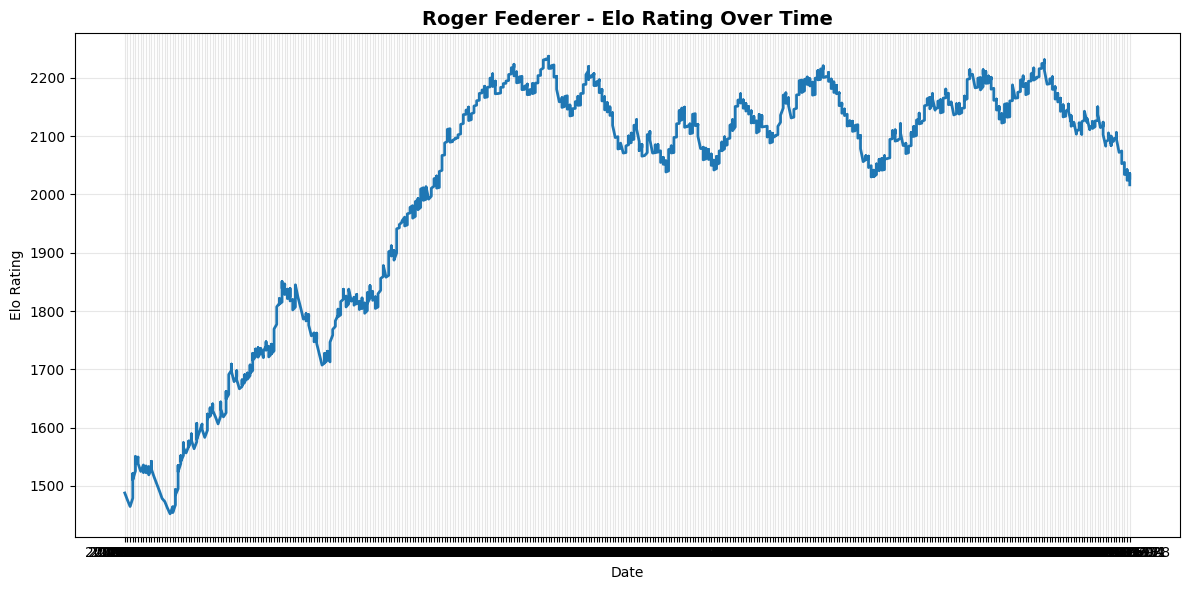

Total matches: 1510
Peak Elo: 2237
Current Elo: 2016


In [10]:
""" Plot Elo rating history for any player """

import matplotlib.pyplot as plt

def plot_player_elo(player_name):
    """Plot Elo rating history for a given player"""
    
    # Filter for player's matches
    player_matches = df_elo[
        (df_elo['winner_name'] == player_name) | 
        (df_elo['loser_name'] == player_name)
    ].copy()
    
    if len(player_matches) == 0:
        print(f"No matches found for {player_name}")
        return
    
    # Get Elo rating after each match
    elo_history = []
    for idx, row in player_matches.iterrows():
        if row['winner_name'] == player_name:
            elo_history.append({
                'date': row['tourney_date'],
                'elo': row['winner_elo_after']
            })
        else:
            elo_history.append({
                'date': row['tourney_date'],
                'elo': row['loser_elo_after']
            })
    
    player_df = pd.DataFrame(elo_history)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(player_df['date'], player_df['elo'], linewidth=2)
    plt.title(f'{player_name} - Elo Rating Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Elo Rating')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Total matches: {len(player_df)}")
    print(f"Peak Elo: {player_df['elo'].max():.0f}")
    print(f"Current Elo: {player_df['elo'].iloc[-1]:.0f}")

# Example usage
plot_player_elo('Roger Federer')

In [17]:
""" Surface-specific Elo Rating System """

class SurfaceEloRatingSystem:
    def __init__(self, k_factor=32, initial_rating=1500):
        """
        Initialize surface-specific Elo rating system
        
        Args:
            k_factor: How much ratings change per match (typically 16-32)
            initial_rating: Starting rating for new players
        """
        self.k_factor = k_factor
        self.initial_rating = initial_rating
        # Separate ratings for each surface
        self.ratings = {
            'Hard': {},
            'Clay': {},
            'Grass': {}
        }
    
    def get_rating(self, player, surface):
        """Get current rating for a player on a specific surface"""
        if surface not in self.ratings:
            return self.initial_rating
        if player not in self.ratings[surface]:
            self.ratings[surface][player] = self.initial_rating
        return self.ratings[surface][player]
    
    def expected_score(self, rating_a, rating_b):
        """Calculate expected score for player A"""
        return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
    
    def update_ratings(self, winner, loser, surface):
        """
        Update ratings after a match on a specific surface
        
        Returns:
            tuple: (winner_rating_before, loser_rating_before, winner_rating_after, loser_rating_after)
        """
        if surface not in self.ratings:
            return None, None, None, None
            
        winner_rating = self.get_rating(winner, surface)
        loser_rating = self.get_rating(loser, surface)
        
        # Expected scores
        winner_expected = self.expected_score(winner_rating, loser_rating)
        loser_expected = self.expected_score(loser_rating, winner_rating)
        
        # Update ratings (winner gets 1, loser gets 0)
        winner_new = winner_rating + self.k_factor * (1 - winner_expected)
        loser_new = loser_rating + self.k_factor * (0 - loser_expected)
        
        self.ratings[surface][winner] = winner_new
        self.ratings[surface][loser] = loser_new
        
        return winner_rating, loser_rating, winner_new, loser_new

# Initialize surface-specific Elo system
surface_elo = SurfaceEloRatingSystem(k_factor=32, initial_rating=1500)

# Calculate surface-specific Elo ratings
surface_elo_records = []

for idx, row in df.iterrows():
    winner = row['winner_name']
    loser = row['loser_name']
    surface = row['surface']
    
    # Skip if missing player names or surface
    if pd.isna(winner) or pd.isna(loser) or pd.isna(surface):
        continue
    
    # Only process Hard, Clay, Grass
    if surface not in ['Hard', 'Clay', 'Grass']:
        continue
    
    # Get ratings before match
    winner_elo_before = surface_elo.get_rating(winner, surface)
    loser_elo_before = surface_elo.get_rating(loser, surface)
    
    # Update ratings
    winner_elo_before, loser_elo_before, winner_elo_after, loser_elo_after = surface_elo.update_ratings(winner, loser, surface)
    
    # Store record
    surface_elo_records.append({
        'tourney_date': row['tourney_date'],
        'surface': surface,
        'winner_name': winner,
        'loser_name': loser,
        'winner_elo_before': winner_elo_before,
        'loser_elo_before': loser_elo_before,
        'winner_elo_after': winner_elo_after,
        'loser_elo_after': loser_elo_after
    })

# Create DataFrame with surface-specific Elo ratings
df_surface_elo = pd.DataFrame(surface_elo_records)
print(f"Calculated surface-specific Elo for {len(df_surface_elo)} matches")
print(f"\nMatches by surface:")
print(df_surface_elo['surface'].value_counts())

Calculated surface-specific Elo for 72814 matches

Matches by surface:
surface
Hard     40871
Clay     24244
Grass     7699
Name: count, dtype: int64


In [22]:
""" View top 10 players by surface-specific Elo rating """

for surface in ['Hard', 'Clay', 'Grass']:
    surface_ratings = pd.DataFrame([
        {'player': player, 'elo': rating}
        for player, rating in surface_elo.ratings[surface].items()
    ]).sort_values('elo', ascending=False)
    
    print(f"\n{'='*50}")
    print(f"Top 10 players on {surface}:")
    print(surface_ratings.head(10).to_string(index=False))


Top 10 players on Hard:
               player         elo
        Jannik Sinner 2210.415592
       Novak Djokovic 2110.629825
        Roger Federer 2062.447761
Juan Martin del Potro 1991.835418
      Robin Soderling 1971.918557
       Carlos Alcaraz 1967.871733
     Alexander Zverev 1939.781963
      Daniil Medvedev 1915.125489
         Taylor Fritz 1904.287314
         Nick Kyrgios 1892.574379

Top 10 players on Clay:
            player         elo
    Novak Djokovic 2026.636220
      Rafael Nadal 2013.662455
    Carlos Alcaraz 1967.992931
   Robin Soderling 1941.979896
Stefanos Tsitsipas 1926.184883
     Roger Federer 1916.969065
  Alexander Zverev 1915.270277
 Matteo Berrettini 1891.016544
       Casper Ruud 1883.854048
       Andy Murray 1843.915871

Top 10 players on Grass:
           player         elo
   Novak Djokovic 2032.460170
    Roger Federer 1959.562851
     Rafael Nadal 1840.159598
   Carlos Alcaraz 1805.855203
      Marin Cilic 1805.340010
     Andy Roddick 1802.766400

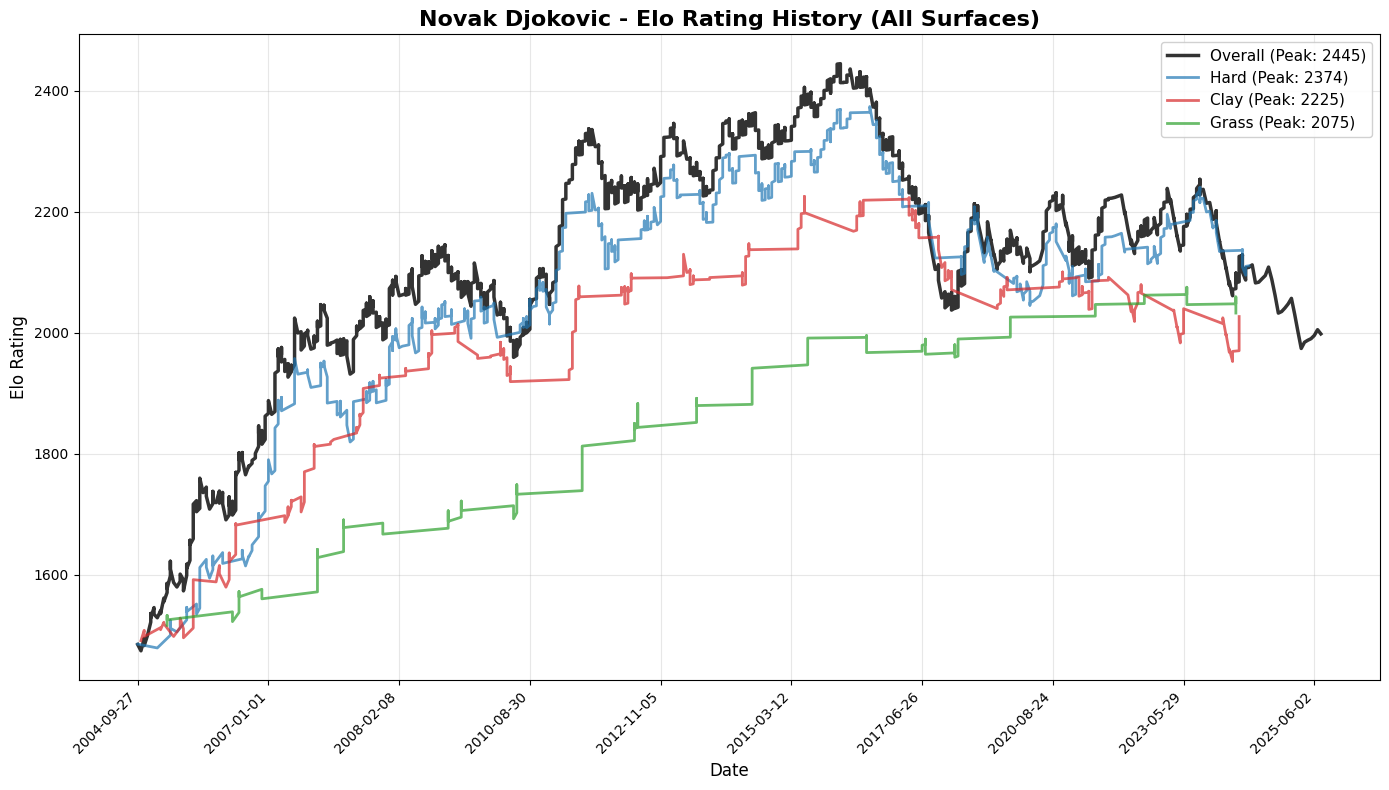

In [35]:
""" Plot all Elo ratings on a single graph """

import matplotlib.pyplot as plt

def plot_all_elos(player_name):
    """
    Plot overall Elo and surface-specific Elo ratings for a given player on one graph
    
    Args:
        player_name: Name of the player to plot
    """
    
    plt.figure(figsize=(14, 8))
    
    # Plot Overall Elo
    player_matches = df_elo[
        (df_elo['winner_name'] == player_name) | 
        (df_elo['loser_name'] == player_name)
    ].copy()
    
    if len(player_matches) > 0:
        elo_history = []
        for idx, row in player_matches.iterrows():
            if row['winner_name'] == player_name:
                elo_history.append({'date': row['tourney_date'], 'elo': row['winner_elo_after']})
            else:
                elo_history.append({'date': row['tourney_date'], 'elo': row['loser_elo_after']})
        
        overall_df = pd.DataFrame(elo_history)
        plt.plot(overall_df['date'], overall_df['elo'], linewidth=2.5, color='black', 
                label=f"Overall (Peak: {overall_df['elo'].max():.0f})", alpha=0.8)
    
    # Plot Surface-specific Elos
    surfaces = ['Hard', 'Clay', 'Grass']
    colors = ['#1f77b4', '#d62728', '#2ca02c']  # Blue, Red, Green
    
    for surface, color in zip(surfaces, colors):
        surface_matches = df_surface_elo[
            ((df_surface_elo['winner_name'] == player_name) | 
             (df_surface_elo['loser_name'] == player_name)) &
            (df_surface_elo['surface'] == surface)
        ].copy()
        
        if len(surface_matches) > 0:
            elo_history = []
            for idx, row in surface_matches.iterrows():
                if row['winner_name'] == player_name:
                    elo_history.append({'date': row['tourney_date'], 'elo': row['winner_elo_after']})
                else:
                    elo_history.append({'date': row['tourney_date'], 'elo': row['loser_elo_after']})
            
            surface_df = pd.DataFrame(elo_history)
            plt.plot(surface_df['date'], surface_df['elo'], linewidth=2, color=color,
                    label=f"{surface} (Peak: {surface_df['elo'].max():.0f})", alpha=0.7)
    
    plt.title(f'{player_name} - Elo Rating History (All Surfaces)', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Elo Rating', fontsize=12)
    plt.legend(loc='best', fontsize=11, framealpha=0.9)
    plt.grid(True, alpha=0.3)
    
    # Reduce x-axis clutter
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))  # Show ~10 date labels
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_all_elos('Novak Djokovic')

In [37]:
""" Create a CSV with all player Elo ratings """

# Combine all ratings into a single DataFrame
all_players = set()
all_players.update(elo.ratings.keys())
for surface in ['Hard', 'Clay', 'Grass']:
    all_players.update(surface_elo.ratings[surface].keys())

# Build the ratings table
ratings_data = []

for player in sorted(all_players):
    ratings_data.append({
        'player': player,
        'elo_overall': elo.get_rating(player),
        'elo_hard': surface_elo.get_rating(player, 'Hard'),
        'elo_clay': surface_elo.get_rating(player, 'Clay'),
        'elo_grass': surface_elo.get_rating(player, 'Grass')
    })

df_ratings = pd.DataFrame(ratings_data)

# Sort by overall Elo
df_ratings = df_ratings.sort_values('elo_overall', ascending=False).reset_index(drop=True)

print(f"Total players: {len(df_ratings)}")
print("\nTop 20 players:")
print(df_ratings.head(20))

""" Save ratings to CSV """

output_path = '../data/processed/player_elo_ratings.csv'
df_ratings.to_csv(output_path, index=False)

Total players: 2663

Top 20 players:
                   player  elo_overall     elo_hard     elo_clay    elo_grass
0           Jannik Sinner  2181.836497  2210.415592  1827.242539  1711.251984
1          Carlos Alcaraz  2125.920552  1967.871733  1967.992931  1805.855203
2         Robin Soderling  2041.996124  1971.918557  1941.979896  1674.710111
3           Roger Federer  2024.090129  2062.447761  1916.969065  1959.562851
4          Novak Djokovic  1997.982485  2110.629825  2026.636220  2032.460170
5   Juan Martin del Potro  1937.558682  1991.835418  1826.495323  1737.651541
6            Taylor Fritz  1923.251838  1904.287314  1750.439494  1671.600053
7            Nick Kyrgios  1909.301023  1892.574379  1675.305712  1718.049681
8         Lorenzo Musetti  1904.550149  1640.127505  1778.195019  1664.136306
9             Jack Draper  1888.564290  1816.186137  1551.728954  1629.042362
10            Holger Rune  1883.532256  1826.721229  1751.286619  1581.600142
11        Grigor Dimitrov  